In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
from scipy.optimize import minimize
import tqdm
from IPython.display import display, Math
import corner
import emcee

np.random.seed(12345)

plt.rcParams['figure.dpi'] = 200

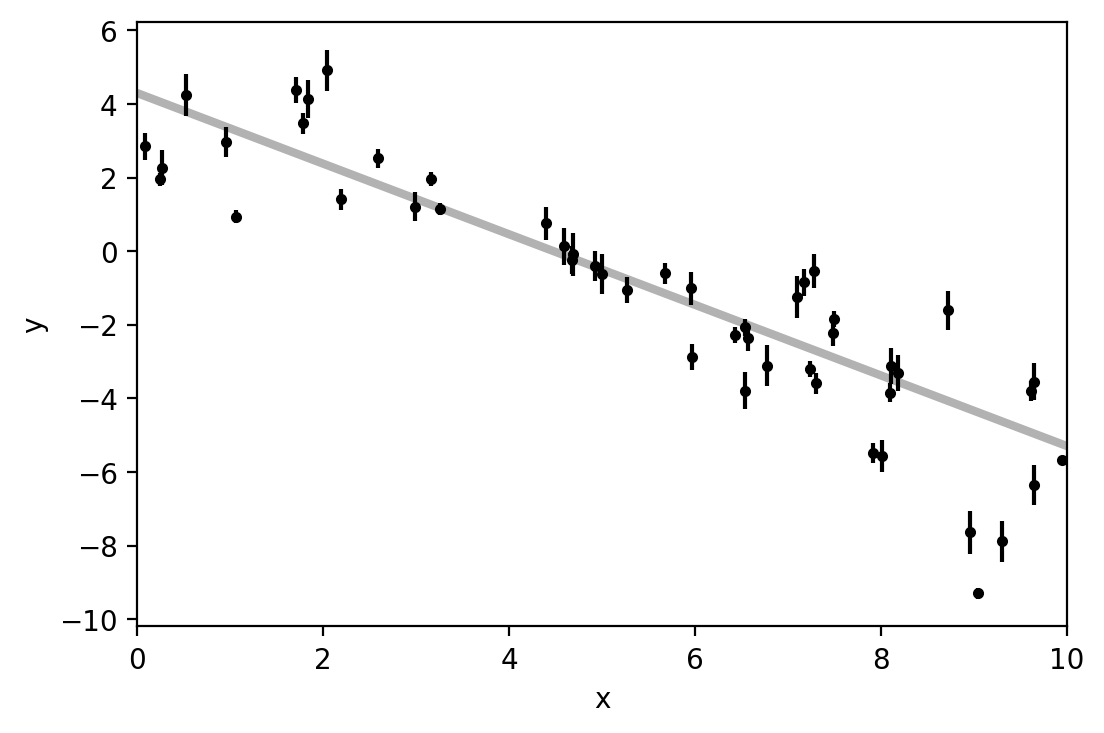

In [35]:
# test linear regression

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y)* np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Simplest Metropolis-Hasting Sampler

In [66]:
# model definition: linear
def modelFunction(x, w):
    m, b, log_f = w
    return m * x + b

In [67]:
# likelyhood function
def logLikelihood(w, x, y, yerr):
    m, b, log_f = w
    model = modelFunction(x, w)
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [68]:
# Prior distribution: only give a limitation range here
def logPrior(w,wrange):
    #m, b, log_f = w
    for i in range(len(w)):
        if (w[i] < wRange[i,0]) or (w[i] > wRange[i,1]):
            return -np.inf
    return 0.0

In [69]:
# Prob = Prior * Likelyhood
def log_probability(w, x, y, yerr):
    lp = logPrior(w,wrange)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(w, x, y, yerr)

In [41]:
# give initial values of parameters
def samplePrior():
    nParams = wRange.shape[0] # the number of parameters
    w = np.zeros(nParams)
    for i in range(nParams):
        w[i] = (wRange[i,1]-wRange[i,0])* np.random.rand() + wRange[i,0] # randomly choose a value in the acceptable range
    
    return w

In [70]:
'''
Not very clearly understood part: sample from a distribution to determine the length of step
'''
# determine the length of the step
def sampleMixture(a, b): #mixture of of Gaussians
    return 10.0**(a - b*np.abs(np.random.randn()/np.sqrt(-np.log(np.random.rand()))))*np.random.randn()

# how to walk in parameter space for each step
def propose(w):
    nParam = len(w)
    wNew = np.zeros_like(w, dtype=np.float64)
    wNew[:] = w

    # Which one should we change? only one parameter changes in each step
    i = int(np.random.rand()*nParam)
    eps = sampleMixture(1,5.0)
    wNew[i] += (wRange[i,1]-wRange[i,0])*eps
        
    return wNew

In [43]:
# main function for MCMC
def MCMC(Nwalkers, Nsteps, data, wrange):
    total_chain = np.zeros((Nwalkers,Nsteps,4))
    for walker in tqdm.tqdm_notebook(range(Nwalkers)): 
        x, y, yerr = data

        # start off at some random w drawn from our prior distribution
        w = samplePrior()
        logp, logl = logPrior(w,wrange), logLikelihood(w,x, y, yerr)

        nParam = w.shape[0] # the value of w plus its likelihood
        chain = np.zeros((Nsteps, nParam + 1))

        # count the number of successful proposals
        ngood = 0

        for i in tqdm.tqdm_notebook(range(Nsteps)):
            wNew = propose(w)
            logpNew = logPrior(wNew,wrange)

            # Only evaluate the likelihood if prior prob isn't zero
            loglNew = -np.Inf
            if logpNew != -np.Inf:
                loglNew = logLikelihood(wNew,x, y, yerr)

            # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w)p(w) )
            logRatio = (logpNew + loglNew) - (logp + logl)
            logRatio = min(0.0, logRatio)

            # Acceptance/rejection
            if np.random.rand() <= np.exp(logRatio):
                w = wNew
                logp = logpNew
                logl = loglNew
                ngood += 1

            chain[i, :-1] = w
            chain[i, -1] = logl
            total_chain[walker,i,:] = chain[i,:]
    return total_chain, ngood/Nsteps

In [44]:
# the number of steps
N = 10**5

# our data
data = [x,y,yerr]

# Ranges in parameter values:
wRange = np.array([[-5.,0.5],[0., 10.], [-10., 1.]])

# run MCMC
chain, goodFrac = MCMC(Nwalkers = 32, Nsteps = N, data = data,wrange = wRange)

print(f"\n\nAcdeptance ratio: {goodFrac}")





Acdeptance ratio: 0.63392


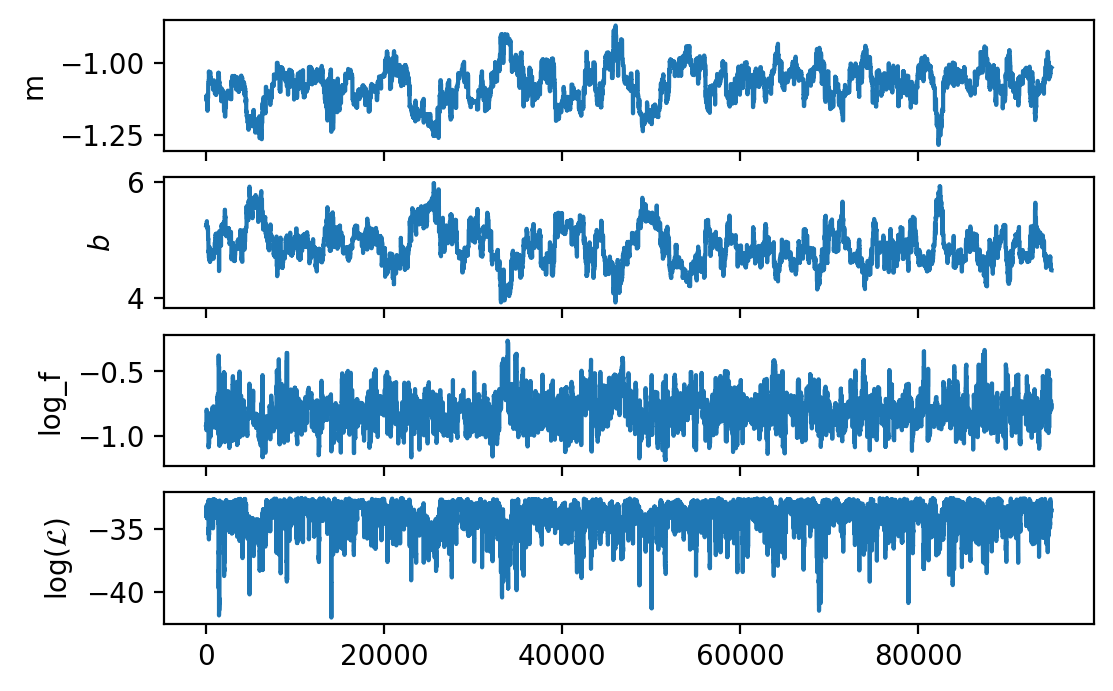

In [82]:
# Have a look on the MC chains 
walker=1
burn=5000
end = -1

m  = chain[walker,burn:end,0]
b = chain[walker,burn:end,1]
log_f = chain[walker,burn:end,2]
ll = chain[walker,burn:end,3]


fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(m)
ax[0].set_ylabel(r'm')

ax[1].plot(b)
ax[1].set_ylabel(r'$b$')

ax[2].plot(log_f)
ax[2].set_ylabel(r'log_f')


ax[3].plot(ll)
ax[3].set_ylabel(r'$\log(\mathcal{L})$');

samples = chain[burn:,:]

In [83]:
# autocorrelated function -> determine every N steps to pick one step
def autocorrelate(x,lags):
    n=len(x)
    # pad 0s to 2n-1
    size=2*n-1
    
    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp, size)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]


def auto(chain, nlag, labs):
    nParam = chain.shape[1]-1
    lags = np.arange(nlag)
    fig, ax = plt.subplots()
    for i in range(nParam):
        result = autocorrelate(chain[:,i],lags)
        ax.plot(result, label=labs[i])
        
    ax.legend()
    ax.set_xlabel('lag k [steps]')
    ax.set_ylabel('P(k)')
    plt.tight_layout();

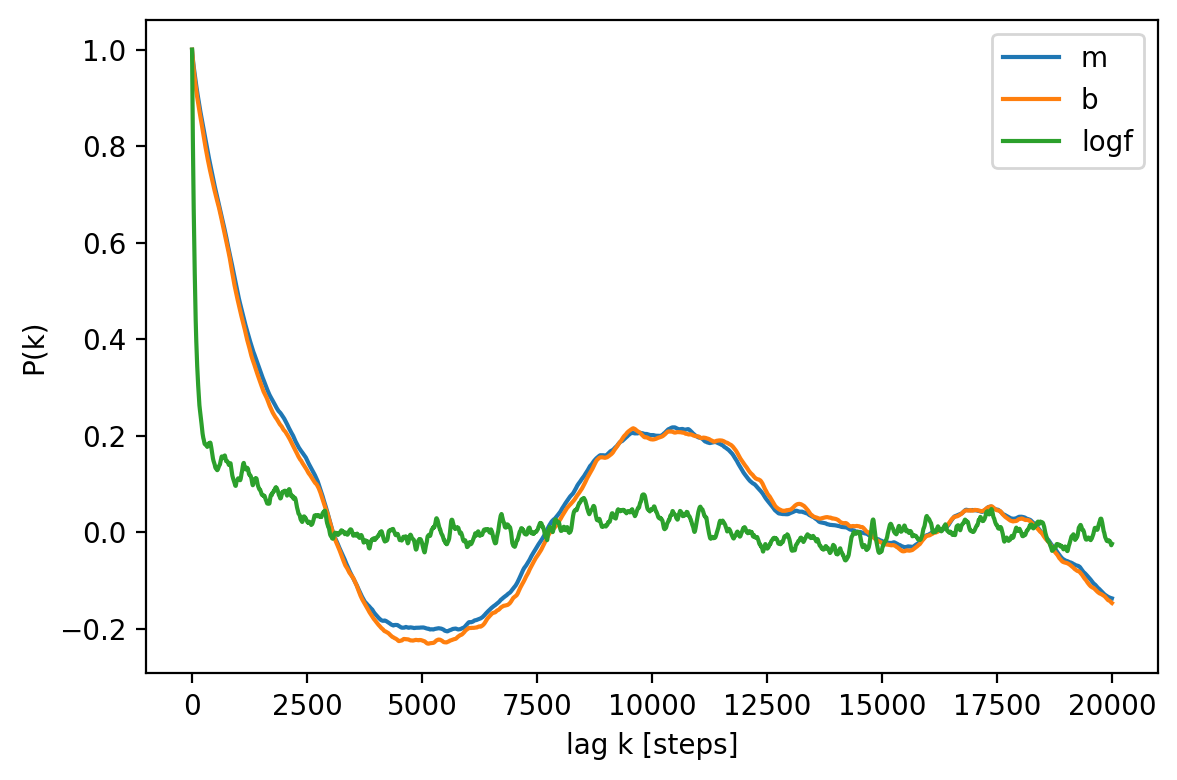

In [84]:
labs = ['m','b','logf']
auto(chain[0,burn:end,:], nlag=20000, labs=labs)

In [132]:
#combine all of chains of walkers
#burn is the first N steps which will be discarded
#thin is every how many steps choose one step to avoid co-corelated between adjacent steps
def flat_chain(chain,burn=100, thin=1500):
    walker = len(chain)
    Nsteps = len(chain[0])
    NParams = len(chain[0][0])
    print(walker,Nsteps,NParams)
    use_chain_point_all = []
    for i in range(walker):
        use_walker_chain = chain[i,burn:,:]
        use_len = len(use_walker_chain)
        index = 0
        while index < use_len:
            use_chain_point_all.append(use_walker_chain[index,:])
            index+=1500
    
    return np.array(use_chain_point_all)
        
        

In [89]:
final_chain = flat_chain(chain,burn=burn, thin=1000)
samples = final_chain

32 100000 4


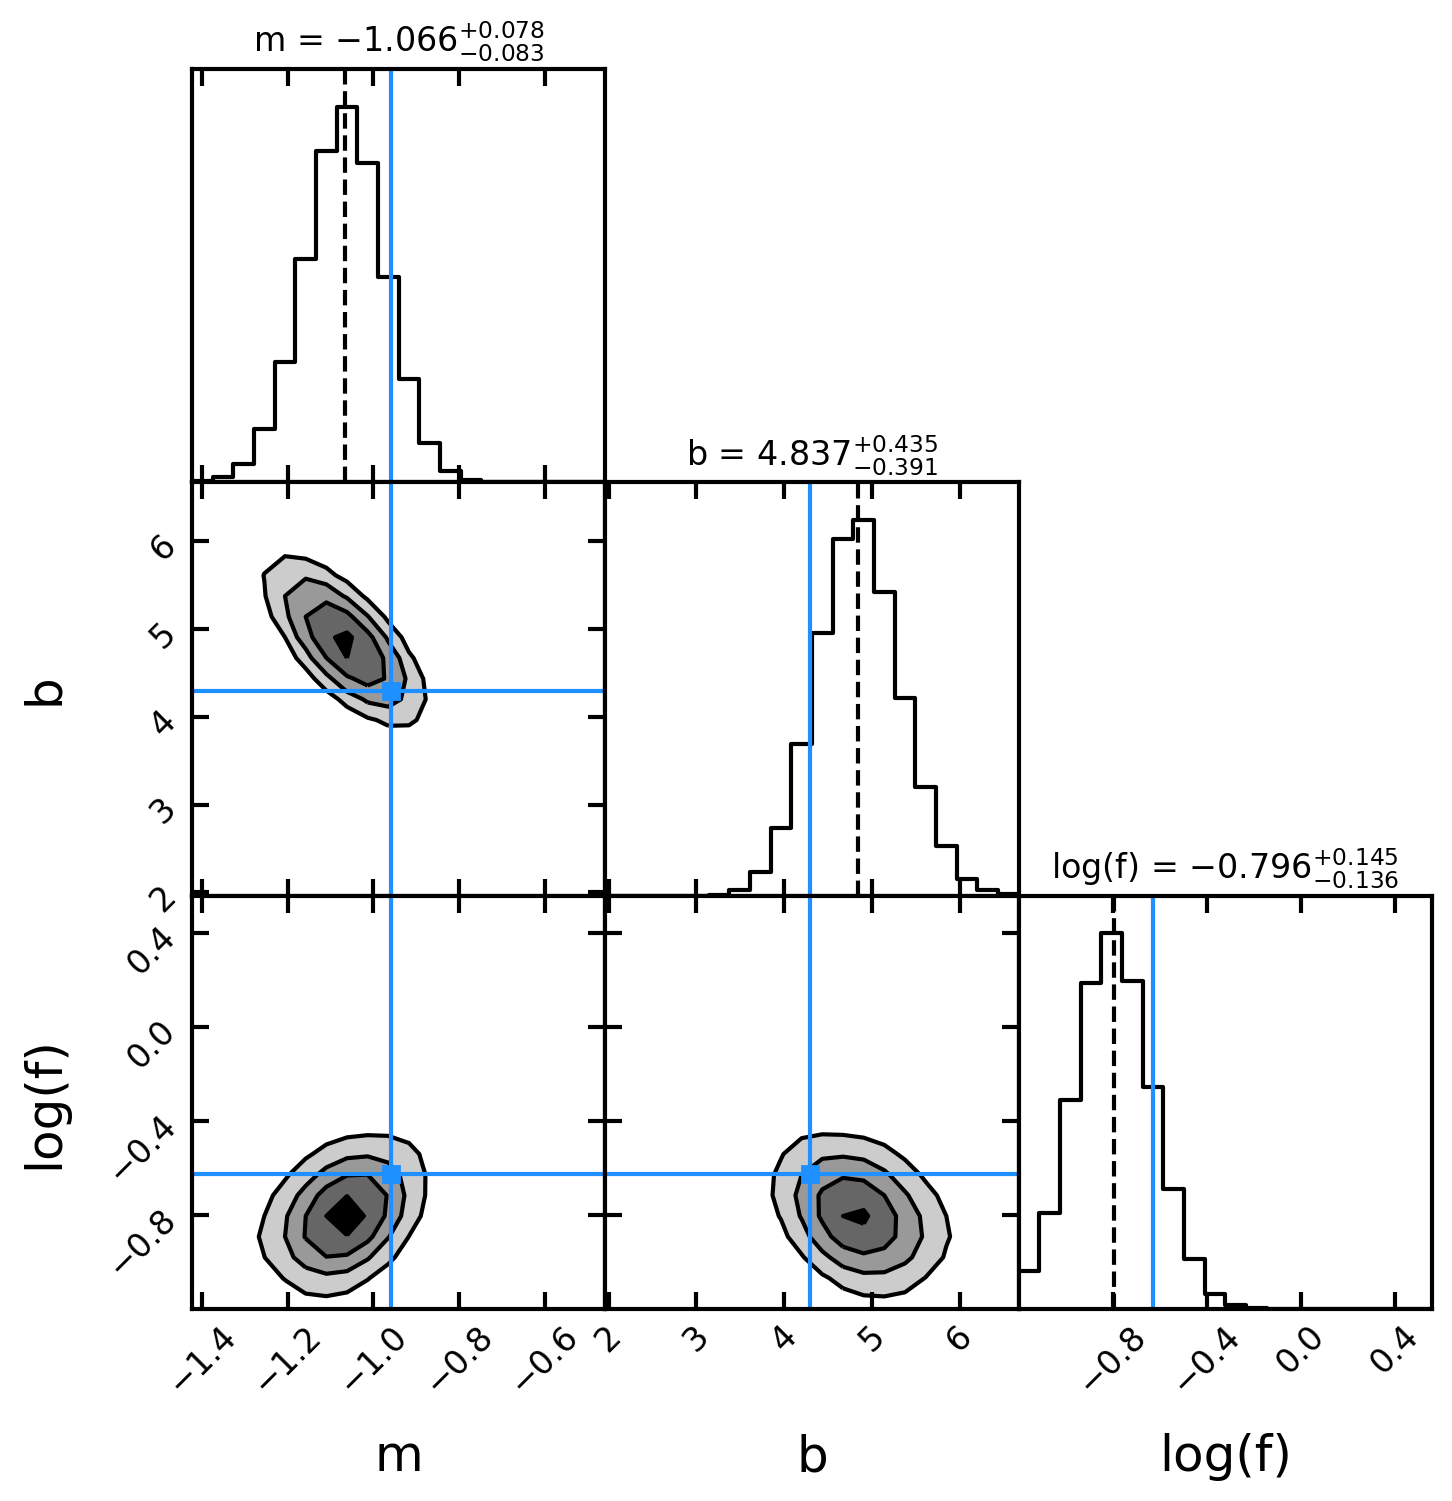

In [90]:
# show corner
labels = ["m", "b", "log(f)"]

fig = corner.corner(\
    samples[:,:-1],\
    truths=[m_true, b_true, np.log(f_true)],\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


Text(0, 0.5, 'y')

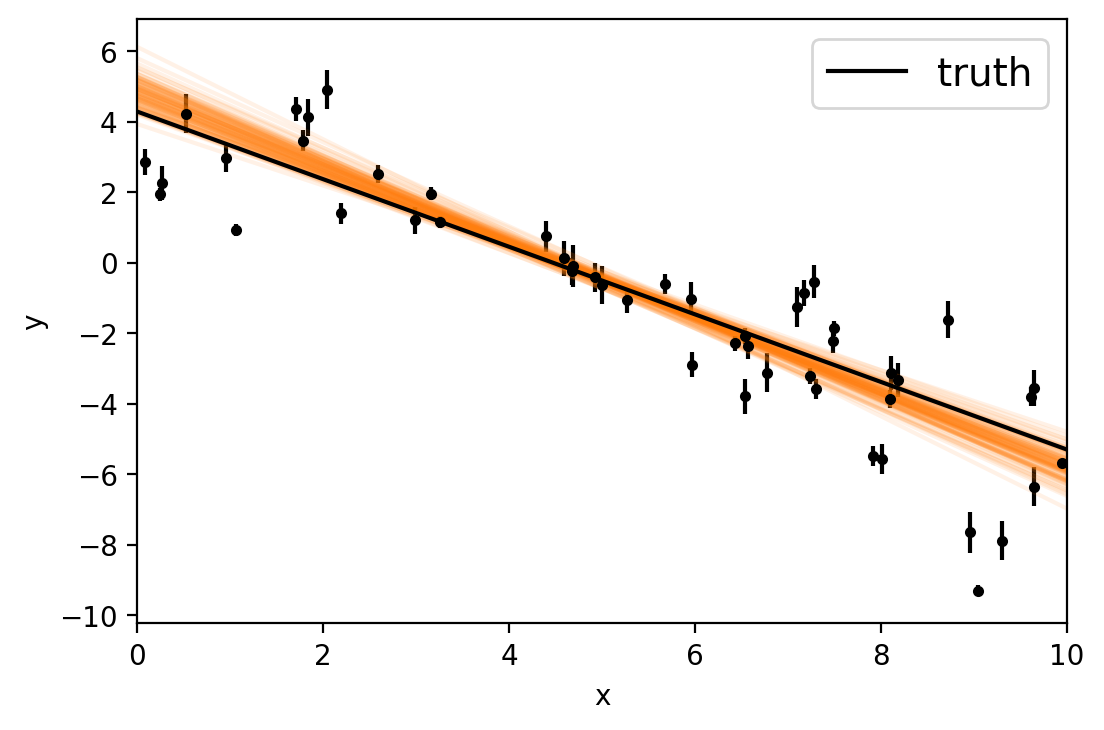

In [91]:
inds = np.random.randint(len(samples), size=100)
for ind in inds:
    sample = samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [92]:
for i in range(3):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [93]:
print(m_true, b_true)

-0.9594 4.294


# Adaptive M-H Sampler

only 1 walker

In [120]:
class MCMC:
    """
    Simple adaptive MCMC sampler:

    Constructor:
    MCMC(data, nParam, labels, modelFunction, priorFunction, indivMove, solveSigma, sigParams, seed)

          data[N, ncol]: N data points consisting of:
              data[:,0]: independent variable to modelFunction
              data[:,1]: dependent variable to be modeled by modelFunction
              data[:,2]: individual measurement sigma's for each data point
                         (used only if solveSigma=False)

                 nParam: number of parameters to be sampled (other than sigma if solveSigma=True)

                 labels: a numba.typed.List of strings for plot labels

    modelFunction(t, w): where t is the independent variable and w a vector of nParam
                         parameters. Returns a vector of N dependent variables.
                         Must be complied with @njit.

       priorFunction(w): prior pdf on parameters w; returns a probability (on [0,1]).
                         Must be complied with @njit.

              indivMove: if True, samples each component of w separately; if False, chooses move
                         from a multivariate normal distribution with a covariance matrix sampled
                         from the Markov chain. Default is False.

             solveSigma: if True, data[:,2] is ignored, and a single sigma on the data is added
                         as a parameter to sample. Default is False.

           sigParams[2]: sigParams[0] gives the width of the gamma function used to sample sigma
                         and
                         sigParams[1] gives the mean of the sampled sigma.
                         Both parameters are modified as the Markov chain proceeds.
                         Default parameters are [5.0, 1.0]

                   seed: the random number seed to start the rng. A default seed is provided.
    """
    def __init__(self, data,
                     nParam,
                     labels,
                     modelFunction,
                     priorFunction,
                     indivMove=False,
                     solveSigma=False,
                     sigParams=np.array([5.0, 1.0]), seed=9812379):

            self.data = data
            self.N = data.shape[0]
            self.labels = labels

            self.modelFunction = modelFunction
            self.priorFunction = priorFunction
            self.nParam = nParam

            self.indivMove = indivMove
            self.solveSigma = solveSigma
            self.sigParams = sigParams

            np.random.seed(seed)
            
    def multivariate_normal(self, mean, cov, *size):
        n = cov.shape[0]
        eps = 1e-10
        norm = np.random.randn(*size,n).reshape(-1,n)
        return ((np.linalg.cholesky(cov + eps*np.eye(n))@norm.T).T + mean).reshape(*size, n)
    
    def logLikelihood(self, w):

        if self.solveSigma:
            # Solve for uncertainties in data
            self.sumOfSquares = ( (self.data[:,1] - self.modelFunction(self.data[:,0], w) )**2 ).sum()
#             logl = -0.5*self.N*np.log(self.sigma2) - 0.5*self.sumOfSquares / self.sigma2
            logl = - 0.5*np.sum((self.data[:,1] - self.modelFunction(self.data[:,0], w) )**2 /self.sigma2+np.log(self.sigma2))

        else:
            # use individual sigmas in data
            ss = ( ( (self.data[:,1] - self.modelFunction(self.data[:,0], w))/self.data[:,2] )**2 ).sum()
            logl = -0.5*self.N*np.log(2*np.pi)- np.log(self.data[:,2]).sum() - 0.5 * ss
            
        return logl
    
    def logPrior(self, w, wrange):
        p =self.priorFunction(w,wrange)
        if p<=0.0:
            return -np.Inf
        else:
            return 0.0

    def propose(self, w, cov):
        wNew = np.zeros_like(w)
        wNew[:] = w

        if self.indivMove:
            j = int(np.random.rand()*self.nParam)
            wNew[j] = w[j] + (2.83**2/self.nParam) * np.random.randn() * np.sqrt(cov[j,j])
        else:
            wNew[:] = w + 0.5/self.nParam * self.multivariate_normal(np.zeros(self.nParam), cov, 1)

        return wNew, 1.0  # symmetric proposal distribution
    
    def covUpdate(self, x):

        n,p = x.shape  # number of samples, number of parameters

        w = np.ones(n) # possibly for weights...

        if self.cov.sum() > 0:

            for i in range(n):
                xi      = x[i,:]
                wsum    = w[i]
                xmeann  = xi
                xmean   = self.mean + wsum/(wsum+self.wsum)*(xmeann-self.mean);
                xcov    = (self.wsum-1)/(wsum+self.wsum-1)*self.cov + \
                         wsum*self.wsum/(wsum+self.wsum-1)/(wsum+self.wsum)*np.outer((xi-self.mean),(xi-self.mean))
                wsum    = wsum+self.wsum
                self.cov[:,:]  = xcov
                self.mean[:] = xmean
                self.wsum = wsum

        else:

            wsum = w.sum()
            self.mean[:].fill(0.0)
            self.cov[:,:].fill(0.0)
            for i in range(p):
                self.mean[i] = (x[:,i]*w).sum()/wsum;
            if wsum>1:
                for i in range(p):
                    for j in range(i+1):
                        self.cov[i,j] = (x[:,i]-self.mean[i]).T @ ((x[:,j]-self.mean[j])*w[i]) /(wsum-1)
                        if i != j:
                            self.cov[j,i] = self.cov[i,j]
            self.wsum = wsum
            
        
    def sampler(self, w0, sig0, wrange, iterations=10**5, sampleCov=100, startCov=100):
        """
            w0: starting point for the chain
          sig0: diagonal of the initial covariance matrix
    iterations: number of steps to perform
     sampleCov: interval in steps between updates of covariance matrix
      startCov: starting step after which covariance matrix is updated every sampleCov steps

        Results are in:

        self.chain[steps, nvar]
        self.logLchain[steps]
        self.acceptRatio[steps]

        """

        w = w0.copy()
        assert self.nParam == len(w)

        self.chain = np.zeros((iterations, self.nParam), dtype=np.float64)
        self.logLchain = np.zeros(iterations, dtype=np.float64)
        self.acceptRatio = np.zeros(iterations, dtype=np.float64)
        self.sigmaChain = np.zeros(iterations, dtype=np.float64)

        # Initialize covariance matrix to the diagonal form given as an argument
        self.wsum = 1
        self.cov = np.zeros((self.nParam,self.nParam))
        for i in range(self.nParam):
            self.cov[i,i] = sig0[i]**2
        self.mean = np.zeros(self.nParam)

        if self.solveSigma:
            # sample initial guess at data variance
            shape = 0.5*self.sigParams[0]
            scale = 1.0/(0.5*self.sigParams[0]*self.sigParams[1])
            self.sigma2 = 1.0/np.random.gamma(shape, scale, size=1)[0]
#             print(self.sigma2)

        # first sample of the chain
        self.chain[0,:] = w
        logp = self.logPrior(w, wrange)
        logl = self.logLikelihood(w)

        # run the chain
        ilast = startCov
        acceptSum = 0
        for i in tqdm.tqdm_notebook(range(iterations)):

            # propose a move and calculate prior
            wNew, qratio = self.propose(w, self.cov)
            logpNew = self.logPrior(wNew, wrange)


            
            # Only evaluate the likelihood if prior prob isn't zero
            loglNew = -np.inf
            if logpNew != -np.Inf:
                loglNew = self.logLikelihood(wNew)
                
            # only when prior and likelyhood function is valid than calculate the total probability    
            if logpNew == -np.Inf or np.isnan(loglNew):
                logRatio = -np.Inf
            else:
                # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w0)p(w0) )
                logRatio = (logpNew+loglNew) - (logp+logl)
            logRatio = min(0.0, logRatio)
            

            # Acceptance/rejection
            rand_ratio = np.random.rand()

            if rand_ratio <= np.exp(logRatio)*qratio:
                w = wNew
                logp = logpNew
                logl = loglNew
                acceptSum += 1

            if self.solveSigma:
                # Gibbs sampler for sigma^2: move is always accepted
                shape = 0.5*(self.sigParams[0] + self.N)
                scale = 0.5*(self.sigParams[0]*self.sigParams[1] + self.sumOfSquares)
                self.sigma2 = 1.0/np.random.gamma(shape, 1.0/scale, size=1)[0]
                self.sigmaChain[i] = np.sqrt(self.sigma2)

            self.chain[i, :] = w
            self.logLchain[i] = logl
            self.acceptRatio[i] = acceptSum/(i+1)

            # update covariance
            if i == ilast + sampleCov:
                self.covUpdate(self.chain[ilast:i,:])
                ilast = i
                """
                for il in range(w.shape[0]):
                    print(np.sqrt(self.cov[il,il]), " ", end="")
                print()
               """

In [121]:
# model definition:
def modelFunction(x, w):
    m, b, log_f = w
    return m * x + b
# prior definition:
def priorFunction(w, wrange):
    for i in range(len(w)):
        if w[i]<wrange[i,0] or w[i]>wrange[i,1]:
            return 0.0
    else:
        return 1.0

In [122]:
# our data
data = [x,y,yerr]

# Ranges in parameter values:
wrange = np.array([[-5.,0.5],[0., 10.], [-10., 1.]],dtype = np.float64)



In [123]:
input_data = np.zeros((len(data[0]),3))
input_data[:,0] = data[0]
input_data[:,1] = data[1]
input_data[:,2] = data[2]

In [127]:
import numba

# begin run adaptive MH MCMC
sigParams = np.array([3.0, 1.0])

labels=['m','b','log_f']
labels = numba.typed.List(labels)

M = MCMC(input_data, 3, labels, modelFunction, priorFunction, 
         indivMove=False, solveSigma=True, sigParams=sigParams, seed=12376523)

wStart = np.array([-4.,7.,-5.]) # initial guess
sigStart = np.array([1.,1.,1.])# inital sigma of parameters

M.sampler(wStart, sigStart, wrange, 2*10**5, 1000, 1000)


In [128]:
def plotChains(M, burn, end):
    n = M.nParam
    nplots = n + 2
    if M.solveSigma:
        nplots += 1
    fig, ax = plt.subplots(nplots,1, figsize=(8,10))
    for i in range(n):
        ax[i].plot(M.chain[burn:end,i])
        ax[i].set_ylabel(M.labels[i])
    if M.solveSigma:
        ax[-3].plot(M.sigmaChain[burn:end])
        ax[-3].set_ylabel('$\sigma$')
    ax[-2].plot(M.logLchain[burn:end])
    ax[-2].set_ylabel('$\log\mathcal{L}$')
    ax[-1].plot(M.acceptRatio[burn:end])
    ax[-1].set_ylabel('acceptance\nratio')
    plt.tight_layout();

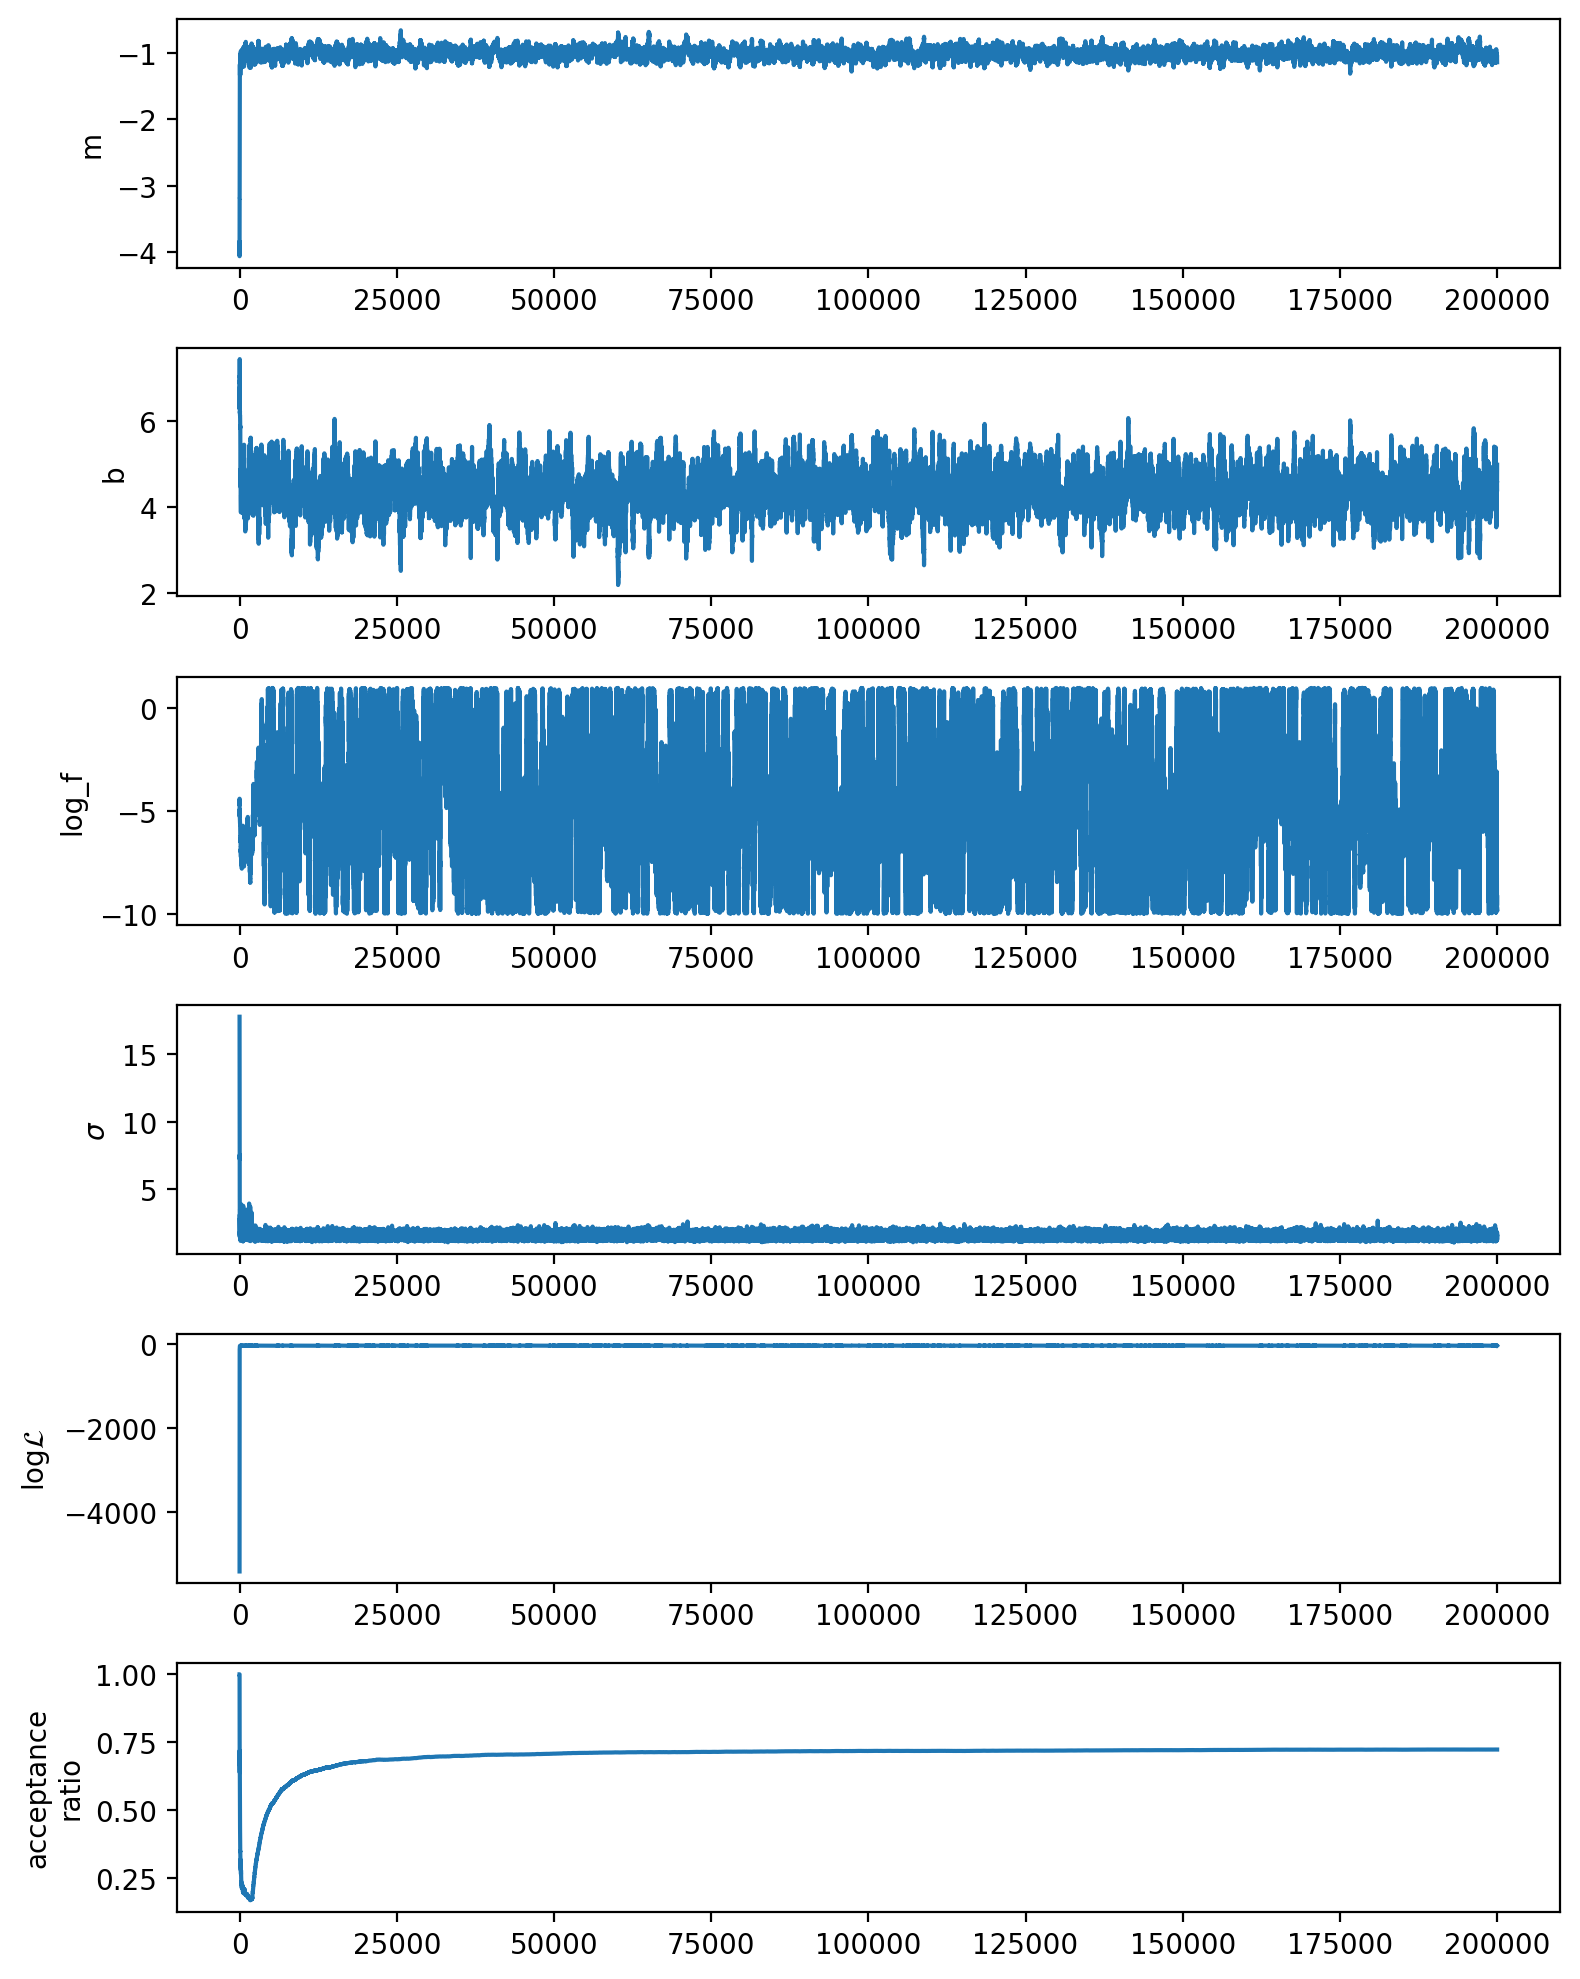

In [130]:
# have a look on the chain
burn = 0
end  = -1
plotChains(M, burn, end)

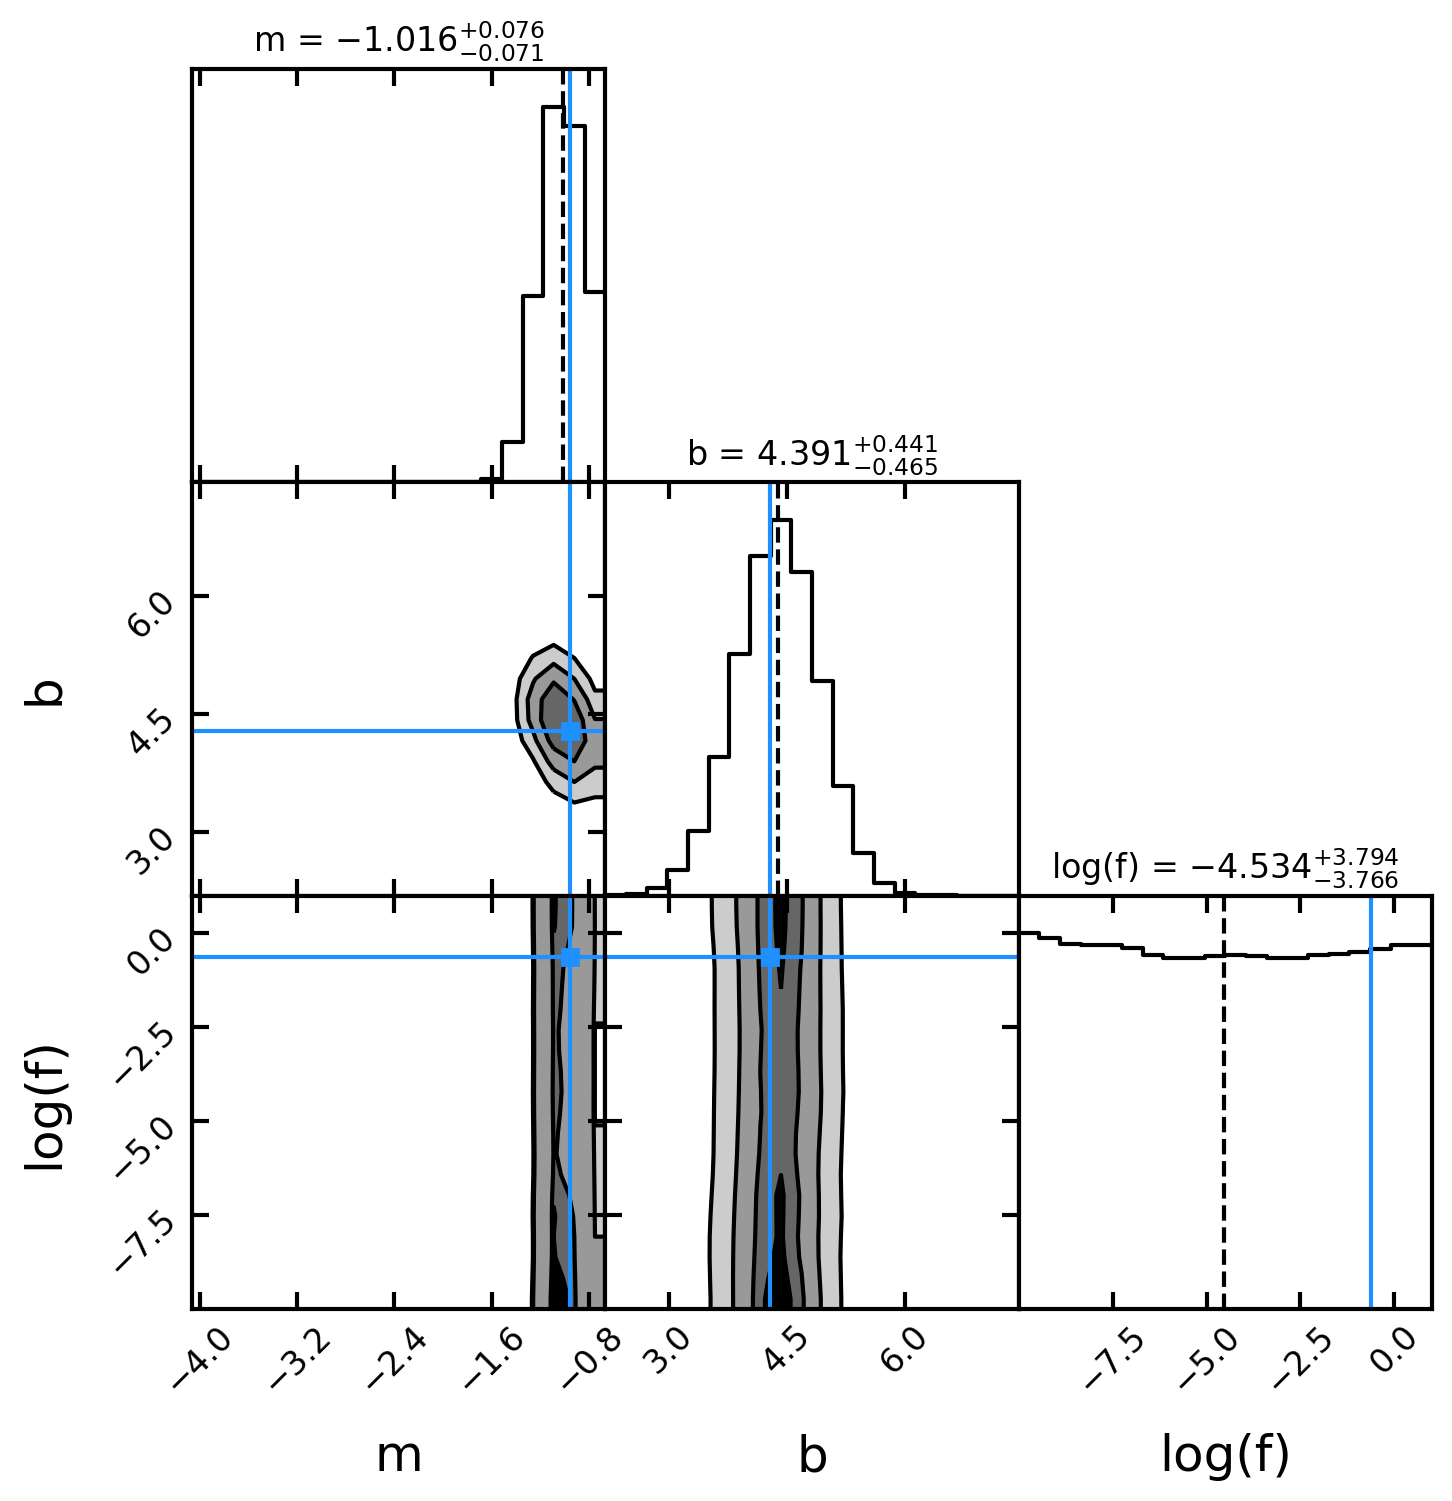

In [131]:
# show corner
labels = ["m", "b", "log(f)"]

fig = corner.corner(\
    M.chain[burn:end,:],\
    truths=[m_true, b_true, np.log(f_true)],\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


In [16]:
m_true,b_true

(-0.9594, 4.294)